In [1]:
import pandas as pd
from datetime import datetime, timedelta

In [2]:
# # خواندن فایل CSV
# df = pd.read_csv("power_code.csv")

In [3]:
# # تبدیل تاریخ با فرمت‌های مختلف
# df['DATE_MILADI'] = pd.to_datetime(df['DATE_MILADI'], format='mixed', errors='coerce')

# # حذف ردیف‌هایی که تبدیل تاریخ در آن‌ها ناموفق بوده
# df = df.dropna(subset=['DATE_MILADI'])

In [4]:
# # ساخت ستون جدید DATE با ساعت اصلاح‌شده از ستون HOUR
# df['DATE'] = df.apply(lambda row: row['DATE_MILADI'].replace(hour=int(row['HOUR']) % 24), axis=1)

# # نمایش چند سطر اول برای بررسی
# print(df[['DATE_MILADI', 'HOUR', 'DATE']].head())

# # ذخیره فایل جدید در صورت نیاز
# df.to_csv('updated_file.csv', index=False)


In [5]:
df = pd.read_csv("../BackUp/updated_file.csv")
# تبدیل تاریخ با فرمت‌های مختلف
df['DATE'] = pd.to_datetime(df['DATE'], format='mixed', errors='coerce')

# حذف ردیف‌هایی که تبدیل تاریخ در آن‌ها ناموفق بوده
df = df.dropna(subset=['DATE'])

In [6]:
from darts import TimeSeries

In [7]:
import pandas as pd

# تبدیل رشته تاریخ به نوع datetime
target_date = pd.to_datetime('6/28/2025 1:00:00 AM')

# فیلتر کردن دیتا فریم
df_filtered = df[(df['UNIT_NO'] == 2) & (df['DATE'] >= target_date)]

# نمایش چند سطر اول برای بررسی
print(df_filtered.head())


          ID_NO  HOUR DATE_MILADI DATE_SHAMSI  POWER CODE  UNIT_NO  ID_EBRAZ  \
966214  1490053     1  2025-06-28    1404/4/7     96   SO        2   1427858   
966215  1490054     2  2025-06-28    1404/4/7     96   SO        2   1427859   
966216  1490055     3  2025-06-28    1404/4/7     97   SO        2   1427860   
966217  1490056     4  2025-06-28    1404/4/7     90   SO        2   1427861   
966218  1490057     5  2025-06-28    1404/4/7     90   SO        2   1427862   

       CODE3  MVAR  DAMA  ROTOOBAT   TOTAL                DATE  
966214     A  21.0  26.0      13.0  1050.0 2025-06-28 01:00:00  
966215     A  19.0  25.0      15.0  1052.0 2025-06-28 02:00:00  
966216     A  19.0  23.0      17.0  1059.0 2025-06-28 03:00:00  
966217     A  18.0  24.0      18.0   992.0 2025-06-28 04:00:00  
966218     A  15.0  24.0      18.0   996.0 2025-06-28 05:00:00  


In [8]:
df['DATE'] = pd.to_datetime(df['DATE'])

In [9]:
duplicates = df_filtered['DATE'].duplicated().sum()
print(f"تعداد تاریخ‌های تکراری: {duplicates}")


تعداد تاریخ‌های تکراری: 0


In [10]:
df_filtered = df_filtered.drop_duplicates(subset='DATE')


In [11]:
df_filtered = df_filtered.groupby('DATE', as_index=False).agg({'POWER': 'mean'})


In [12]:
from darts import TimeSeries

series = TimeSeries.from_dataframe(
    df_filtered,
    time_col='DATE',
    value_cols='POWER',
    freq='h'  # به جای 'H'
)


In [13]:
from darts.dataprocessing.transformers import Scaler
from sklearn.preprocessing import MinMaxScaler

In [14]:
scaler = Scaler(MinMaxScaler(feature_range=(0, 1)))
series_scaled = scaler.fit_transform(series)

In [15]:

train_ratio = 0.95
train, test = series_scaled.split_after(train_ratio)

print(f"اندازه داده آموزش: {len(train)} ساعت")
print(f"اندازه داده تست: {len(test)} ساعت")
from darts.models import RNNModel

اندازه داده آموزش: 272 ساعت
اندازه داده تست: 15 ساعت


c:\Users\pishva_r\Anaconda3\envs\test2\Lib\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


In [16]:

model = RNNModel(
    model='LSTM', # نوع مدل: LSTM
    hidden_dim=100,
    n_rnn_layers=6,   
    dropout=0.2, # نرخ dropout برای جلوگیری از بیش‌برازش
    input_chunk_length=24, # طول پنجره ورودی (مثلاً 24 ساعت قبلی)
    output_chunk_length=12, # طول پیش‌بینی (مثلاً 12 ساعت آینده)
    training_length=36, 
    n_epochs=100,
    random_state=42 # برای تکرارپذیری
)

ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.


In [17]:
model.fit(train)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 445 K  | train
6 | V               | Linear           | 101    | train
-------------------------------------------------------------
445 K     Trainable params
0         Non-trainable params
445 K     Total params
1.781     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


RNNModel(model=LSTM, hidden_dim=100, n_rnn_layers=6, dropout=0.2, training_length=36, input_chunk_length=24, output_chunk_length=12, n_epochs=100, random_state=42)

In [18]:
pred = model.predict(n=len(test), series=train)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

In [19]:
pred = scaler.inverse_transform(pred)
test = scaler.inverse_transform(test)

In [20]:
from darts.metrics import rmse, mae
# محاسبه خطاها
rmse_score = rmse(test, pred)
mae_score = mae(test, pred)
print(f"RMSE: {rmse_score:.2f}")
print(f"MAE: {mae_score:.2f}")

RMSE: 1.84
MAE: 1.38


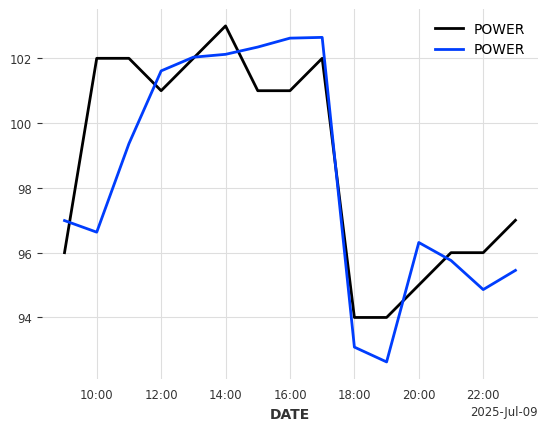

In [21]:
import matplotlib.pyplot as plt

test.plot(label='')
pred.plot(label='')
plt.legend()
plt.show()